In [1]:
# Crea escenarios socioeconómicos a
# partir de la identidad de KAYA.

import pandas as pd
import numpy as np

from scipy import optimize

from matplotlib import pyplot as plt

In [2]:
path_d = "../../datos/"
fname = "economic_indicators_1960_2008.csv"

# Columnas para las tasas de crecimiento.
col_t = ["Inicio", "Fin", "Población", "PIB real",
    "Intensidad energética", "Intensidad de carbono",
    "Emisiones de CO2", "Emisiones KAYA"]

datos = pd.read_csv(path_d + fname, index_col = "Año", skiprows = [1])

# Columnas de los datos históricos.
col_d = datos.columns

# Se agregan los indicadores KAYA a los datos históricos.
datos["PIB per cápita"] = datos[col_d[1]] / datos[col_d[0]]
datos[col_t[4]] = datos[col_d[2]] / datos[col_d[1]]
datos[col_t[5]] = datos[col_d[3]] / datos[col_d[2]]

# Se actualizan las columnas de los datos históricos.
col_d = datos.columns

datos.head()

,Población,PIB real,Energía primaria,Emisiones de CO2,PIB per cápita,Intensidad energética,Intensidad de carbono
Año,,,,,,,
1960.0,3.009886e+09,8.750980e+12,1834017.812,9.060156e+06,2907.412857,2.095786e-07,4.940059
1961.0,3.051183e+09,9.082970e+12,1880521.015,9.057335e+06,2976.868155,2.070381e-07,4.816397
1962.0,3.104591e+09,9.610780e+12,1983346.682,9.375305e+06,3095.666866,2.063669e-07,4.727013
1963.0,3.169943e+09,1.008900e+13,2109888.633,9.911853e+06,3182.707146,2.091276e-07,4.697808
1964.0,3.235720e+09,1.074860e+13,2207318.057,1.041968e+07,3321.856861,2.053587e-07,4.720518


In [3]:
# Tasas de crecimiento.
# i =
#    0: promedio de todo el periodo histórico.
#    1: promedio a utilizar para proyección.
#    2: periodo a proyectar.
#    3: variación de la tasa proyectada.
periodos = np.array([
    (1960, 2008),
    (1971, 2008),
    (2009, 2100),
    (np.nan, np.nan)
    ])

# Se crea un DataFrame vacío.
tasa = pd.DataFrame(
    np.full((periodos.shape[0], len(col_t)),
    fill_value = np.nan), columns = col_t)

# Se llena la fecha de los periodos históricos.
for i in range(0, tasa.shape[0] - 2):
    tasa.iat[i, 0] = periodos[i, 0]
    tasa.iat[i, 1] = periodos[i, 1]

# Se calcula la tasa de crecimiento en el periodo dado.
for i in range(2, tasa.shape[1] - 1):
    tasa.loc[0:1, col_t[i]] = (
        ( datos.loc[tasa.loc[0:1, col_t[1]], col_t[i]].array
        / datos.loc[tasa.loc[0:1, col_t[0]], col_t[i]].array )
        ** ( 1 /  ( tasa.iloc[:-2,1 ].array - 
        tasa.iloc[:-2, 0].array + 1) ) - 1 )

# Se establece la tasa de crecimiento futuro.
i = tasa.shape[0] - 2
tasa.loc[i] = [periodos[i, 0], periodos[i, 1], 
    tasa.iat[i - 1, 2], tasa.iat[i - 1, 3],
    tasa.iat[i - 1, 4], tasa.iat[i - 1, 5], np.nan, 0]

# Se establece la variación en la tasa de crecimiento.
i = tasa.shape[0] - 1
tasa.loc[i] = [np.nan, np.nan, 0.965, 1.00, 
    1.01, 1.01, np.nan, np.nan]

# Se calcula la tasa de emisiones KAYA.
for i in range(0, tasa.shape[0] - 1):
    tasa.iat[i, len(col_t) - 1] = (
        tasa.iloc[i, 2:(len(col_t) - 2)].sum())

tasa.head()

,Inicio,Fin,Población,PIB real,Intensidad energética,Intensidad de carbono,Emisiones de CO2,Emisiones KAYA
0,1960.0,2008.0,0.016351,0.037251,0.001317,-0.013467,0.024629,0.041452
1,1971.0,2008.0,0.015310,0.031678,-0.010505,-0.002407,0.018384,0.034077
2,2009.0,2100.0,0.015310,0.031678,-0.010505,-0.002407,NaN,0.034077
3,NaN,NaN,0.965000,1.000000,1.010000,1.010000,NaN,NaN


In [4]:
# Se crea una DataFrame con el tamaño requerido para
# los datos proyectados.
proyeccion = pd.DataFrame(
    np.zeros((int(periodos[2, 1] - periodos[2, 0] + 2),
    len(col_d))), columns = col_d,
    index = range(int(periodos[2, 0] - 1),
    int(periodos[2, 1] + 1)) )
proyeccion.index.rename("Año", inplace = True)

# Se toman las columnas que se calculan directamente de
# las tasas de crecimiento.
cols = col_t[2:-2]

# Se copia el valor inicial.
proyeccion.loc[periodos[2, 0] - 1] = datos.loc[periodos[2, 0] - 1]

# Se proyectan los datos de acuerdo a las tasas de
# crecimiento.
proyeccion.loc[periodos[2, 0]:, cols] = (
    proyeccion.loc[2008, cols].array * ( 1 + 
    np.expand_dims(tasa.loc[tasa.shape[0] - 2, cols], 0) * (
    np.expand_dims(tasa.loc[tasa.shape[0] - 1, cols], 0) **
    np.expand_dims((proyeccion.loc[periodos[2, 0]:].index.array
    - proyeccion.index[1]), 1) )
    ).cumprod(axis = 0)
    )

# Se proyectan las emisiones a partir de la identidad
# de KAYA.

# Se calcula el PIB per capita y la energía primaria.
proyeccion.loc[periodos[2, 0]:, "PIB per cápita"] = (
    proyeccion.loc[periodos[2, 0]:, "PIB real"] / 
    proyeccion.loc[periodos[2, 0]:, "Población"] )
proyeccion.loc[periodos[2, 0]:, "Energía primaria"] = (
    proyeccion.loc[periodos[2, 0]:, "Intensidad energética"] * 
    proyeccion.loc[periodos[2, 0]:, "PIB real"] )

KAYA = True

# Se proyectan las emisiones a partir de la identidad
# de KAYA.
if KAYA:
    cols.remove("PIB real")
    proyeccion.loc[periodos[2, 0]:, "Emisiones de CO2"] = ( 
        proyeccion.loc[2008, "Emisiones de CO2"] * ( ( 
        np.expand_dims(tasa.loc[tasa.shape[0] - 2, cols], 0) * (
        np.expand_dims(tasa.loc[tasa.shape[0] - 1, cols], 0) **
        np.expand_dims((proyeccion.loc[periodos[1, 0]:].index.array
        - proyeccion.index[0]), 1) ) ).sum(axis = 1)[:-1]
        + np.array(proyeccion["PIB per cápita"]
        .pct_change().array[1:]) + 1
        ).cumprod()
        )
# Se calculan las emisiones a partir de la intensidad 
# energética.
else:
    proyeccion.loc[periodos[2, 0]:, "Emisiones de CO2"] = (
        proyeccion.loc[periodos[2, 0]:, "Intensidad de carbono"] *
        proyeccion.loc[periodos[2, 0]:, "Energía primaria"] )

proyeccion.tail()

,Población,PIB real,Energía primaria,Emisiones de CO2,PIB per cápita,Intensidad energética,Intensidad de carbono
Año,,,,,,,
2096,1.010834e+10,8.170724e+14,4.139652e+07,7.821299e+07,80831.481006,5.066444e-08,1.813522
2097,1.011507e+10,8.429559e+14,4.163096e+07,7.826495e+07,83336.604828,4.938687e-08,1.803045
2098,1.012157e+10,8.696595e+14,4.185590e+07,7.829274e+07,85921.368347,4.812907e-08,1.792525
2099,1.012785e+10,8.972089e+14,4.207106e+07,7.829609e+07,88588.291762,4.689104e-08,1.781961
2100,1.013391e+10,9.256311e+14,4.227616e+07,7.827473e+07,91339.975177,4.567279e-08,1.771354


(0.5, 4.0)

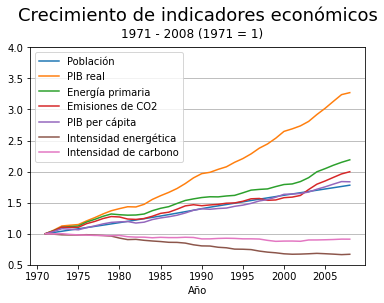

In [5]:
# Se crea una lista para guardar los valores normailzados.
crecimiento = [None] * 3

# Se grafica el periodo histórico.
i = 0

# Se normalizan los datos con respecto al año inicial.
crecimiento[i] = datos.loc[periodos[1, 0]:] / datos.loc[periodos[1, 0]]

# Se crea la gráfica.
fig, ax = plt.subplots(1, 1)
crecimiento[i].plot(yticks = np.linspace(
    0.5, 4.5, 8, endpoint = False), ax = ax)
ax.grid(axis = "y")
ax.set_title("Crecimiento de indicadores económicos\n",
    fontsize = "18")
fig.suptitle(str(int(periodos[1, 0])) + " - " +
    str(int(periodos[1, 1])) + " (" + str(int(periodos[1, 0]))
    + " = 1)", fontsize = "12", y = 0.95)
ax.set_ylim(0.5)

(0.0, 12.157083079703959)

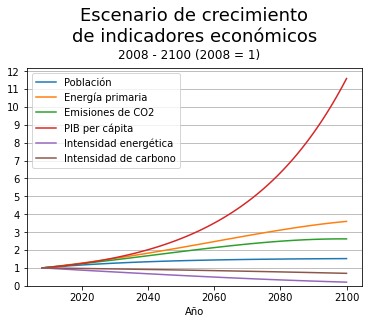

In [6]:
# Se grafica el periodo proyectado.

i = 1

# Se normalizan los datos con respecto al año inicial.
crecimiento[i] = ( proyeccion.loc[periodos[2, 0] - 1:]
    / proyeccion.loc[periodos[2, 0] - 1] )

# Se crea la gráfica.
fig, ax = plt.subplots(1, 1)
( crecimiento[i].loc[:, col_d.drop("PIB real")]
    .plot(yticks = np.linspace(0, 13, 13,
    endpoint = False), ax = ax ) )
ax.grid(axis = "y")
ax.set_title("Escenario de crecimiento\n" +
    "de indicadores económicos\n", fontsize = "18")
fig.suptitle(str(int(periodos[2, 0]) - 1) + " - " +
    str(int(periodos[2, 1])) + " (" + str(int(periodos[2, 0]) - 1)
    + " = 1)", fontsize = "12", y = 0.95)
ax.set_ylim(0)

(0.0, 3.0)

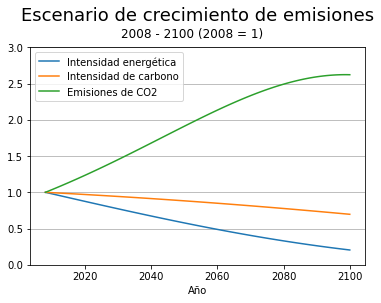

In [7]:
# Se grafican únicamente las tasas de crecimiento e
# intensidades para una mejor lectura.

i = 1

# Se crea la gráfica.
fig, ax = plt.subplots(1, 1)
( crecimiento[i].loc[:, ["Intensidad energética",
    "Intensidad de carbono", "Emisiones de CO2"]]
    .plot(yticks = np.linspace(0, 3.5, 7, endpoint = False),
    ax = ax) )
ax.grid(axis = "y")
ax.set_title("Escenario de crecimiento de emisiones\n",
    fontsize = "18")
fig.suptitle(str(int(periodos[2, 0]) - 1) + " - " +
    str(int(periodos[2, 1])) + " (" + str(int(periodos[2, 0]) - 1)
    + " = 1)", fontsize = "12", y = 0.95)
ax.set_ylim(0)

(0.0, 22.33549895027424)

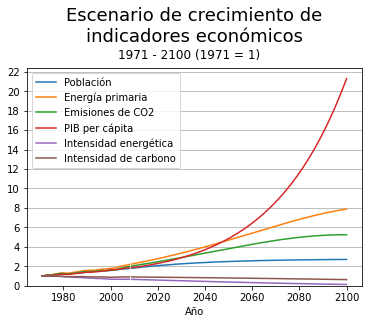

In [8]:
# Se grafican ambos periodos
i = 2

# Se normalizan los datos con respecto al año inicial.
crecimiento[i] = ( pd.concat([datos.loc[periodos[1, 0]:],
    proyeccion.loc[periodos[2, 0]:]], axis = 0)
    / datos.loc[periodos[1, 0]])

# Se crea la gráfica.
fig, ax = plt.subplots(1, 1)
( crecimiento[i].loc[:, col_d.drop("PIB real")]
    .plot(yticks = np.linspace(0, 24, 12, endpoint = False),
    ax = ax) )
ax.grid(axis = "y")
ax.set_title("Escenario de crecimiento de\n"
    + "indicadores económicos\n",
    fontsize = "18")
fig.suptitle(str(int(periodos[1, 0])) + " - " +
    str(int(periodos[2, 1])) + " (" + str(int(periodos[1, 0]))
    + " = 1)", fontsize = "12", y = 0.95)
ax.set_ylim(0)

In [9]:
fname = "CO2 emissions.csv"

# Columnas para el modelo de dos compartimientos.
col_m = ( ["Box_" + str(x) for x in range(1, 6)] + 
    ["C", "F", "T_a", "T_o"] )

historico = pd.read_csv( path_d + fname, 
    index_col = "year", skiprows = [1] )
historico.rename_axis("Año", axis = "index",
    inplace = True)
historico.rename(columns = {"emissions": col_t[6]},
    inplace = True)

# Se agregan las columnas.
historico[col_m] = 0

# Valor de concentración inicial
C_0 = 275
historico.iloc[0, 1] = C_0

# Valores del modelo.
gamma = np.array([0.13, 0.2, 0.32, 0.25, 0.1])
alpha = np.array([1, np.exp(-1/363), np.exp(-1/74),
    np.exp(-1/17), np.exp(-1/2)])
beta = 0.00047
lmbda = np.array([0, 0.0256, 1.14891, 0.00738, 0.00568])

In [10]:
# Se carga la anomalía de temperatura observada.

fname = "T_anomalia.csv"

t_real = pd.read_csv(path_d + fname, index_col = "Año")
t_real = t_real.loc[t_real.index[0]: tasa.iat[0, 1]]

In [11]:
# Calcula todo el modelo para el periodo del índice.
# Con optimize = True, calcula la suma de los mínimos
# cuadrados para poder optimizar el valor de const
# (lambda 2).
def proy_lmbda(df, const, optimize = False):
    for i in range(df.index[0] + 1,
        df.index[-1] + 1):

        # Se calcula la concentración en cada caja. 
        df.loc[i, col_m[0:5]] = ( 
            alpha * df.loc[i - 1, col_m[0:5]]
            + gamma * beta * df.loc[i, col_t[6]]
            )

    # Se suman las concentraciones.
    df[col_m[5]] = df[col_m[0:5]].sum(axis = 1)
    # Se calcula el forzamiento.
    df[col_m[6]] = 5.35 * np.log(
        df[col_m[5]] / df.iat[0,6] )

    for i in range(df.index[0] + 1,
        df.index[-1] + 1):

        # Se calcula la temperatura atmosférica.
        df.loc[i, col_m[7]] = ( 
            df.loc[i - 1, col_m[7]] + 
            lmbda[1] * ( const * df.loc[i, col_m[6]] 
            - df.loc[i - 1, col_m[7]] ) + 
            lmbda[3] * ( df.loc[i - 1, col_m[8]] 
            - df.loc[i - 1, col_m[7]] ) )

        # Se calcula la temperatura del océano.
        df.loc[i, col_m[8]] = ( 
            df.loc[i - 1, col_m[8]] + 
            lmbda[4] * ( df.loc[i - 1, col_m[7]] 
            - df.loc[i - 1, col_m[8]] ) )
    
    # Se calcula la suma de los mínimos cuadrados.
    if optimize:
        min_err = np.vectorize( lambda x, y: ( x - y ) ** 2 )
        anomalia = min_err(t_real.iloc[:,0],
            df.loc[1850:, col_m[-2]]).sum()

        return anomalia

# Calcula con const fijo y sin optimizar.
def proy(df):
    proy_lmbda(df, lmbda[2])

# Wrapper de la función para optimizar.
def proy_err(var):
    anomalia = proy_lmbda(historico,
         var, optimize = True)
    return anomalia


Lambda 2 ajustado: 1.1477
Sensibilidad del clima: 4.26 °C


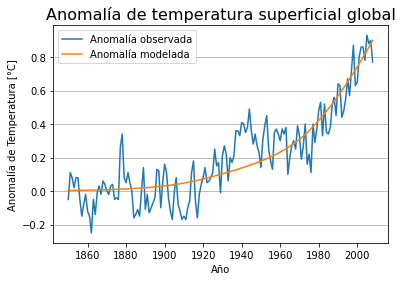

In [12]:
# Se ajusta el modelo a la temperatura observada.
lmbda[2] = optimize.minimize(proy_err, lmbda[2],
    options = {"maxiter": 10}).x[0]
print("Lambda 2 ajustado: " + f"{lmbda[2]:.4f}")

# Se evalúa el modelo para los datos históricos.
proy(historico)

# Sensibilidad del clima.
print("Sensibilidad del clima: " +
    f"{lmbda[2] * 5.35 * np.log(2):.2f}"
    + " °C")

# Se grafican las temperaturas observadas y modeladas.
fig, ax = plt.subplots(1, 1)
t_real.iloc[:,0].plot(ax = ax)
historico.loc[1850:, col_m[-2]].plot(ax = ax)
ax.set_title("Anomalía de temperatura superficial global",
    fontsize = 16)
ax.grid(axis = "y")
ax.set_ylabel("Anomalía de Temperatura [°C]")
ax.legend(["Anomalía observada",
    "Anomalía modelada"])

In [13]:
# Proyección de escenarios futuros.

modelos = []

modelos.append( pd.DataFrame(
        index = proyeccion.index,
        columns = historico.columns ) )

# Los valores iniciales son los finales
# del histórico.
modelos[0].iloc[0] = (
    historico.iloc[historico.shape[0] - 1] )

# El escenario 1 tiene emisiones constantes.
modelos[0].iloc[:, 0] = modelos[0].iat[0, 0]
for i in range(1, 3):
    modelos.append( modelos[0].copy() )

# El escenario 2 tiene un incremento anual de 2.5%.
v_tasa_c02 = 1 + 2.5 / 100
tasa_co2 = ( np.array([1] + [v_tasa_c02]
    * ( modelos[1].shape[0] -1 ) ).cumprod()
    )
modelos[1].iloc[:, 0] *= tasa_co2

# El escenario 3 usa lo☼ valores de KAYA.
modelos[2].iloc[:, 0] = ( proyeccion[col_t[6]]
    / (3.67 * 1000) + 
    ( historico.iat[historico.shape[0] - 1, 0] - 
    ( proyeccion.at[proyeccion.index[0], col_t[6]]
    / (3.67 * 1000) ) )
    )

# Se evalúan los escenarios.
for i in modelos:
    proy(i)

col_v = ["Modelo", 
    "Temperatura superficial de la atmósfera en 2100 [°C]",
    "Forzamiento en 2100 [W/m^2]",
    "Concentración de CO2 en 2100 [ppm]",
    "Respuesta transitoria del clima [°C]"]

valores = pd.DataFrame({col_v[0]: ["Cte. 2008", "+ 2.5 %", "KAYA"],
    col_v[1]: [x.at[x.index[-1], "T_a"] for x in modelos],
    col_v[2]: [x.at[x.index[-1], "F"] for x in modelos],
    col_v[3]: [x.at[x.index[-1], "C"] for x in modelos],
    # Se busca el valor más cercano a un doblamiento
    # de la concentración de CO2.
    col_v[4]: [x.iloc[ ( ( x["C"] - (2 * historico.iat[0, 1]) )
        .abs().argsort()[:1] ),
        np.where(historico.columns == "T_a")[0] ].iat[0, 0]
        for x in modelos]
    })
valores.set_index("Modelo", inplace = True)

valores

,Temperatura superficial de la atmósfera en 2100 [°C],Forzamiento en 2100 [W/m^2],Concentración de CO2 en 2100 [ppm],Respuesta transitoria del clima [°C]
Modelo,,,,
Cte. 2008,1.382928,1.889827,534.389209,1.382928
+ 2.5 %,3.762351,6.459434,1255.459253,1.055293
KAYA,2.411367,3.624048,738.985170,1.150926
